## Late Fusion Multi-Modal Classifier

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import os
import PIL
import sklearn
import pickle
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras

In [2]:
from utils import data_utils, model_utils, models

#### Data Loading and Pre-processing

In [3]:
label_map = label_map = {
    'geol_geow': 0, 
    'geol_sed': 1, 
    'gphys_gen': 2, 
    'log_sum': 3, 
    'pre_site': 4, 
    'vsp_file': 5
}

In [4]:
doc_data = data_utils.DocumentData(label_map, 2020, drop_nans='or')

In [5]:
doc_data.load_text_data()
doc_data.text_train.shape

(4177, 2000)

In [6]:
doc_data.load_image_data(image_size=200, n_pages=10)
doc_data.image_train.shape

(4177, 10, 200, 200, 1)

#### Late Fusion image C-LSTM & text CNN Classifier

Text feature extraction & classification:

In [27]:
text_input = keras.layers.Input(shape=2000)
embeddings = keras.layers.Embedding(doc_data.vocab_length, 150, input_length=2000)(text_input)
conv_1d = keras.layers.Conv1D(filters=200, kernel_size=7, activation='relu')(embeddings)
global_pooling = keras.layers.GlobalMaxPool1D()(conv_1d)
flatten = keras.layers.Flatten()(global_pooling)
dense_layer = keras.layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.5))(flatten)
text_features = keras.layers.Dropout(0.3)(dense_layer)

Image feature extraction & classification:

In [28]:
image_input = keras.layers.Input(shape=(10, 200, 200, 1))
conv_2d_1 = keras.layers.TimeDistributed(keras.layers.Conv2D(20, 7, activation='relu', padding='same'))(image_input)
pool_2d_1 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4))(conv_2d_1)
conv_2d_2 = keras.layers.TimeDistributed(keras.layers.Conv2D(50, 5, activation='relu', padding='valid'))(pool_2d_1)
pool_2d_2 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4))(conv_2d_2)
extracted_features = keras.layers.TimeDistributed(keras.layers.Flatten())(pool_2d_2)
lstm_1 = keras.layers.LSTM(1000, return_sequences=True)(extracted_features)
image_features = keras.layers.LSTM(1000, dropout=0.5)(lstm_1)

Softmax classification layer:

In [29]:
concat_features = keras.layers.concatenate([text_features, image_features])
output = keras.layers.Dense(6, activation='softmax')(concat_features)

Build and compile model:

In [30]:
model = keras.models.Model(inputs=[text_input, image_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10, 200, 200 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 10, 200, 200, 1000        input_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 2000, 150)    23451000    input_5[0][0]                    
_______________________________________________________________________________________

Train and evaluate model:

In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

In [34]:
history = model.fit(
    [doc_data.text_train, doc_data.image_train], 
    doc_data.y_train, 
    epochs=400, 
    validation_data=([doc_data.text_val, doc_data.image_val], doc_data.y_val), 
    callbacks=[early_stopping]
)

Epoch 1/400
131/131 [==============================] - 64s 490ms/step - loss: 14.7319 - accuracy: 0.3641 - val_loss: 2.9980 - val_accuracy: 0.5158
Epoch 2/400
131/131 [==============================] - 46s 353ms/step - loss: 1.5110 - accuracy: 0.6284 - val_loss: 1.0338 - val_accuracy: 0.6622
Epoch 3/400
131/131 [==============================] - 44s 336ms/step - loss: 0.7835 - accuracy: 0.7577 - val_loss: 0.7939 - val_accuracy: 0.7455
Epoch 4/400
131/131 [==============================] - 44s 336ms/step - loss: 0.6135 - accuracy: 0.8260 - val_loss: 0.7645 - val_accuracy: 0.7589
Epoch 5/400
131/131 [==============================] - 44s 335ms/step - loss: 0.5405 - accuracy: 0.8434 - val_loss: 0.7100 - val_accuracy: 0.7694
Epoch 6/400
131/131 [==============================] - 44s 336ms/step - loss: 0.4665 - accuracy: 0.8638 - val_loss: 0.7897 - val_accuracy: 0.7560
Epoch 7/400
131/131 [==============================] - 44s 334ms/step - loss: 0.4198 - accuracy: 0.8801 - val_loss: 0.7047 

In [35]:
model.evaluate([doc_data.text_test, doc_data.image_test], doc_data.y_test)

41/41 [==============================] - 4s 98ms/step - loss: 0.6548 - accuracy: 0.7971


[0.654849112033844, 0.7970903515815735]

In [37]:
y_hat = model.predict([doc_data.text_test, doc_data.image_test])

In [38]:
y = np.argmax(doc_data.y_test, axis=-1)

In [40]:
y_hat = np.argmax(y_hat, axis=-1)

In [41]:
labels = [label for label in label_map]
print(metrics.classification_report(y, y_hat, target_names=labels))

              precision    recall  f1-score   support

   geol_geow       0.83      0.80      0.82       322
    geol_sed       0.90      0.77      0.83       203
   gphys_gen       0.74      0.82      0.78       208
     log_sum       0.59      0.79      0.67       208
    pre_site       0.93      0.78      0.85       231
    vsp_file       0.97      0.82      0.89       134

    accuracy                           0.80      1306
   macro avg       0.83      0.80      0.81      1306
weighted avg       0.82      0.80      0.80      1306



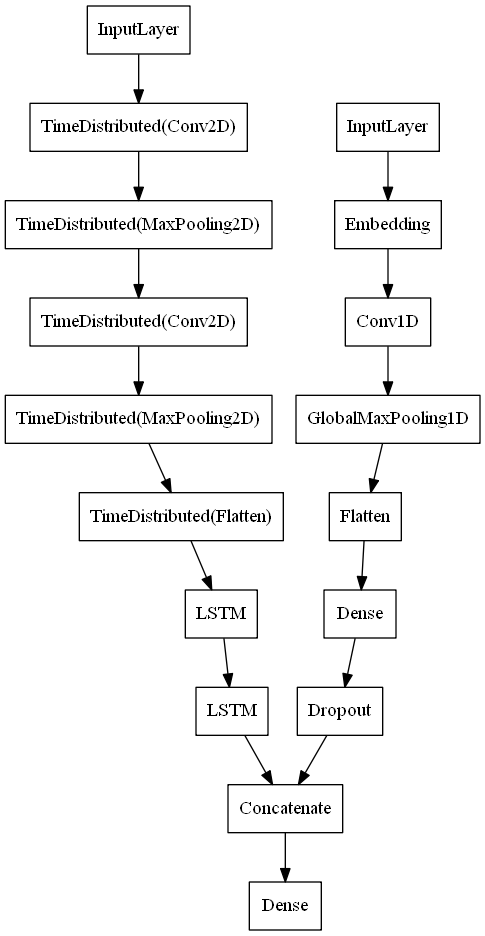

In [32]:
keras.utils.plot_model(model, show_layer_names=False)